In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import trimesh
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from nets import EncodeProcessDecode, UnsharedEncodeProcessDecode
from utils import info, visualize


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
graphs = torch.load("data/cantilever_1.pt", weights_only=False)
train_x = torch.cat([g["node"].x for g in graphs], dim=0)
train_y = torch.cat([g["node"].y for g in graphs], dim=0)
train_me = torch.cat([g["node", "mesh", "node"].edge_attr for g in graphs], dim=0)
train_ce = torch.cat([g["node", "contact", "node"].edge_attr for g in graphs], dim=0)
print("Training data shape:", train_x.shape, train_y.shape)

stats = {
    "x_mean": train_x.mean(dim=0),
    "x_std": train_x.std(dim=0),
    "y_mean": train_y.mean(dim=0),
    "y_std": train_y.std(dim=0),
    "me_mean": train_me.mean(dim=0),
    "me_std": train_me.std(dim=0),
    "ce_mean": train_ce.mean(dim=0),
    "ce_std": train_ce.std(dim=0),
}

print("x means:", stats["x_mean"])
print("x stds:", stats["x_std"])
print("y means:", stats["y_mean"])
print("y stds:", stats["y_std"])
print("Mesh edge_attr means:", stats["me_mean"])
print("Mesh edge_attr stds:", stats["me_std"])
print("Contact edge_attr means:", stats["ce_mean"])
print("Contact edge_attr stds:", stats["ce_std"])


def normalize_graph(graph, stats):
    # Clone to avoid overwriting original data in memory if needed
    g = graph.clone()

    # Handle std = 0 case by replacing with 1 (skips normalization for constant features)
    x_std_safe = torch.where(
        stats["x_std"][3:] > 0, stats["x_std"][3:], torch.ones_like(stats["x_std"][3:])
    )
    y_std_safe = torch.where(
        stats["y_std"] > 0, stats["y_std"], torch.ones_like(stats["y_std"])
    )
    me_std_safe = torch.where(
        stats["me_std"] > 0, stats["me_std"], torch.ones_like(stats["me_std"])
    )
    ce_std_safe = torch.where(
        stats["ce_std"] > 0, stats["ce_std"], torch.ones_like(stats["ce_std"])
    )

    g["node"].x[:, 3:] = (g["node"].x[:, 3:] - stats["x_mean"][3:]) / x_std_safe
    g["node"].y = (g["node"].y - stats["y_mean"]) / y_std_safe
    g["node", "mesh", "node"].edge_attr = (
        g["node", "mesh", "node"].edge_attr - stats["me_mean"]
    ) / me_std_safe
    g["node", "contact", "node"].edge_attr = (
        g["node", "contact", "node"].edge_attr - stats["ce_mean"]
    ) / ce_std_safe
    return g


loader = DataLoader(
    [normalize_graph(g, stats) for g in graphs], batch_size=1, shuffle=False
)

Using device: cuda
Training data shape: torch.Size([2858, 9]) torch.Size([2858, 1])
x means: tensor([ 5.0735e-02,  9.4822e-01,  1.0497e-03, -4.9843e+00,  5.0124e+00,
         2.5003e+01,  3.4990e-03,  0.0000e+00,  0.0000e+00])
x stds: tensor([ 0.2195,  0.2216,  0.0324,  4.0020,  3.9976, 15.5999,  0.1088,  0.0000,
         0.0000])
y means: tensor([0.0694])
y stds: tensor([0.1281])
Mesh edge_attr means: tensor([0.0000, 0.0000, 0.0000, 0.9584])
Mesh edge_attr stds: tensor([0.5051, 0.5060, 0.6553, 0.1487])
Contact edge_attr means: tensor([ 0.0000,  0.0775, -0.2531,  1.0737,  0.5301,  0.0000,  0.0000])
Contact edge_attr stds: tensor([0.0000, 0.7917, 0.7437, 0.1178, 0.0345, 0.0000, 0.0000])


In [41]:
latent_dim = 128
node_dim, mesh_edge_dim, contact_edge_dim, output_dim = info(graphs[0], debug=True)


Node feature dim: 9
Mesh edge feature dim: 4
Contact edge feature dim: 7
Output dim: 1
Keys: ['x', 'y', 'edge_index', 'edge_attr']
Number of nodes: 2858
Number of edges: 17152
Number of mesh edges: 17136
Number of contact edges: 16


In [36]:
# Debugging
g0 = graphs[0]
g1 = graphs[1]
x0 = g0["node"].x
x1 = g1["node"].x
dx = (x0 - x1).abs().max().item()
print("max |x0-x1| =", dx)

f0 = x0[:, -3:]
f1 = x1[:, -3:]
print("nonzero force nodes g0:", (f0.abs().sum(dim=1) > 0).sum().item())
print("nonzero force nodes g1:", (f1.abs().sum(dim=1) > 0).sum().item())

e0 = g0["node", "contact", "node"].edge_index
e1 = g1["node", "contact", "node"].edge_index
print("contact edges g0:", e0.size(1), "g1:", e1.size(1))
print("contact edge_index identical:", torch.equal(e0, e1))

max |x0-x1| = 7.765928745269775
nonzero force nodes g0: 3
nonzero force nodes g1: 3
contact edges g0: 16 g1: 15
contact edge_index identical: False


In [65]:
model = EncodeProcessDecode(
    node_dim=node_dim,
    mesh_edge_dim=mesh_edge_dim,
    contact_edge_dim=contact_edge_dim,
    output_dim=output_dim,
    latent_dim=latent_dim,
    message_passing_steps=15,
    use_layer_norm=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_nodes = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_pred = model(batch)
        y_true = batch["node"].y

        loss = F.mse_loss(y_pred, y_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes
    avg_loss = total_loss / total_nodes
    loss_history.append(avg_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "stats": stats,
    },
    "models/model.pth",
)

Epoch 50/500, Loss: 0.061793
Epoch 100/500, Loss: 0.017226
Epoch 150/500, Loss: 0.014695
Epoch 200/500, Loss: 0.009995
Epoch 250/500, Loss: 0.005638
Epoch 300/500, Loss: 0.005262
Epoch 350/500, Loss: 0.007010
Epoch 400/500, Loss: 0.010392
Epoch 450/500, Loss: 0.002965
Epoch 500/500, Loss: 0.003315


# Traning Loss

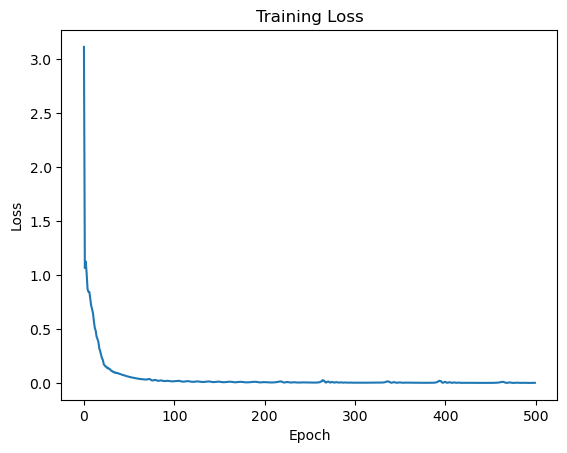

In [66]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Visualize Results

In [67]:
import pyvista


pyvista.OFF_SCREEN = True

mesh = trimesh.load_mesh("meshes/cantilever.stl")
g = graphs[0]
visualize(mesh, g, jupyter_backend="html")


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [68]:
model.eval()

g_pred = g.clone()
# g_normalized = normalize_graph(g.cpu(), stats)
g_pred["node"].y = model(normalize_graph(g, stats).to(device)).detach()
g_pred["node"].y = g_pred["node"].y * stats["y_std"].to(device) + stats["y_mean"].to(
    device
)
visualize(mesh, g_pred, jupyter_backend="html")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [ ]:
import numpy as np

forces = np.array([[0, 2, 1], [1, 2, 3]])
weights = np.array([[1 / 4, 1 / 4, 1 / 2], [1 / 3, 1 / 3, 1 / 3]])

forces[:, None, :] * weights[:, :, None]

## Example Graph

In [43]:
num_nodes = 4
edge_index = torch.tensor(
    [[0, 1], [1, 0], [0, 2], [2, 0], [0, 3], [3, 0], [2, 3], [3, 2]]
).T
edge_attr = torch.tensor(
    [
        [3.0, 1.0],
        [-3.0, -1.0],
        [1.0, 2.0],
        [-1.0, -2.0],
        [2.0, 2.0],
        [-2.0, -2.0],
        [0.0, 3.0],
        [0.0, -3.0],
    ]
)

D = edge_attr.size(1)
idx = edge_index[1].unsqueeze(-1).expand(-1, D)
agg = torch.zeros((num_nodes, D))
deg = torch.zeros((num_nodes, 1))
deg.scatter_add_(
    0,
    edge_index[1].unsqueeze(-1),
    torch.ones((edge_index.size(1), 1)),
).clamp_(min=1.0)
agg.scatter_add_(0, idx, edge_attr)
print(agg)
print(deg)

tensor([[-6., -5.],
        [ 3.,  1.],
        [ 1., -1.],
        [ 2.,  5.]])
tensor([[3.],
        [1.],
        [2.],
        [2.]])


In [32]:
print(edge_index.shape, edge_attr.shape)

torch.Size([8, 2]) torch.Size([8, 2])


In [42]:
edge_index.size(1)

8